In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [18, 10]

## Loading data


In [2]:
data = pd.read_stata('HCMST 2017 fresh sample for public sharing draft v1.1.dta')
data.head()

,CaseID,CASEID_NEW,qflag,weight1,weight1_freqwt,weight2,weight1a,weight1a_freqwt,weight_combo,weight_combo_freqwt,...,hcm2017q24_met_through_family,hcm2017q24_met_through_friend,hcm2017q24_met_through_as_nghbrs,hcm2017q24_met_as_through_cowork,w6_subject_race,interracial_5cat,partner_mother_yrsed,subject_mother_yrsed,partner_yrsed,subject_yrsed
0,2,2014039,Qualified,NaN,NaN,0.8945,NaN,NaN,0.277188,19240.0,...,no,no,no,no,White,no,12.0,14.0,12.0,14.0
1,3,2019003,Qualified,0.9078,71115.0,NaN,0.9026,70707.0,1.020621,70841.0,...,no,no,no,yes,White,no,12.0,16.0,17.0,17.0
2,5,2145527,Qualified,0.7205,56442.0,NaN,0.7164,56121.0,0.810074,56227.0,...,no,no,no,no,White,no,9.0,7.5,14.0,17.0
3,6,2648857,Qualified,1.2597,98682.0,1.3507,1.2524,98110.0,0.418556,29052.0,...,no,no,no,no,White,no,16.0,12.0,12.0,12.0
4,7,2623465,Qualified,0.8686,68044.0,NaN,0.8636,67652.0,0.976522,67781.0,...,no,no,yes,no,White,no,14.0,17.0,16.0,16.0


### Columns, which was used by someone else

In [3]:
used_columns = ['Q19', 'Q21A_Year', 'Q23', 'Q26', 'Q27', 'Q28', 'Q9', 'age_when_met','duration',
                'hcm2017q24_internet_dating', 'partner_mother_yrsed', 'partner_yrsed', 'ppage', 'ppc21310',
                'ppgender', 'ppp20072', 'ppwork', 'time_from_met_to_rel', 'w6_19', 'w6_how_manyppethm',
                'w6_q16', 'w6_q20', 'w6_q21a_year', 'w6_q23', 'w6_q24_length', 'w6_q27', 'w6_q32', 'w6_sex_frequency']

### Chosen columns:
     pphhsize - Household Size
     relate_duration_at_w6_years - july 2017-year and month when rel started
     w6_friend_connect_4 - partner knows my friends and I know my partner's friends before metting
     w6_otherdate - In the past year, have you ever met someone for dating, for romance, or for sex
     S1 - Are you married? (output)

### Dropping rows, which had nulls and changing categorical data

In [4]:
data = data[['pphhsize', 'relate_duration_at_w6_years', 'w6_friend_connect_4', 'w6_otherdate', 'S1']].dropna()
data['pphhsize'] = data['pphhsize'].astype(float)
data = pd.get_dummies(data)

#### Rows with an answer *Refused* in *w6_otherdate* also admitted as null

In [5]:
data = data.loc[data['w6_otherdate_Refused'] == 0] 
data.drop('w6_otherdate_Refused', axis=1, inplace=True)

#### Renaming columns and splitting for train and test

In [6]:
data.rename(columns={'relate_duration_at_w6_years': 'relate_duration',
            'w6_friend_connect_4_Yes': 'friends_connect',
            'w6_otherdate_No, I have not met anyone for dating, romance, or sex besides [Partner Name] in the past year.': 'otherdate',
            'S1_Yes, I am Married':'married'},
            inplace=True)
data = data.reset_index()
X_data, y_data = data[['pphhsize', 'relate_duration', 'friends_connect', 'otherdate']], data[['married']]
y_data = np.array(y_data).ravel()
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data)

### Training model

In [7]:
cls = RandomForestClassifier()
cls.fit(X_train, y_train)
y_pred = cls.predict(X_test)

### Which part of ydata is 1

In [8]:
y_test.sum()/y_test.shape[0]

0.7379912663755459

### Basic metric

In [9]:
accuracy_score(y_pred, y_test)

0.8034934497816594

### Ceteris paribus for *pphhsize* and *relate_duration*

In [10]:
def ceteris_paribus(X_data, chosen_feature, chosen_index):
    x_axis = sorted(set(X_data[chosen_feature]))
    used_data = pd.DataFrame({chosen_feature: x_axis})
    features = X_data.iloc[chosen_index].to_dict()
    for key, item in features.items():
        if key not in chosen_feature:
            used_data[key] = item
    y_axis = cls.predict_proba(used_data)[:,0]
    x_point = X_data.loc[chosen_index, chosen_feature]
    y_point = y_axis[x_axis == x_point]
    return x_axis, y_axis, x_point, y_point

#### Chosen example

In [66]:
chosen_index = 844
X_data.iloc[chosen_index]

pphhsize           6.000000
relate_duration    9.916667
friends_connect    0.000000
otherdate          1.000000
Name: 844, dtype: float64

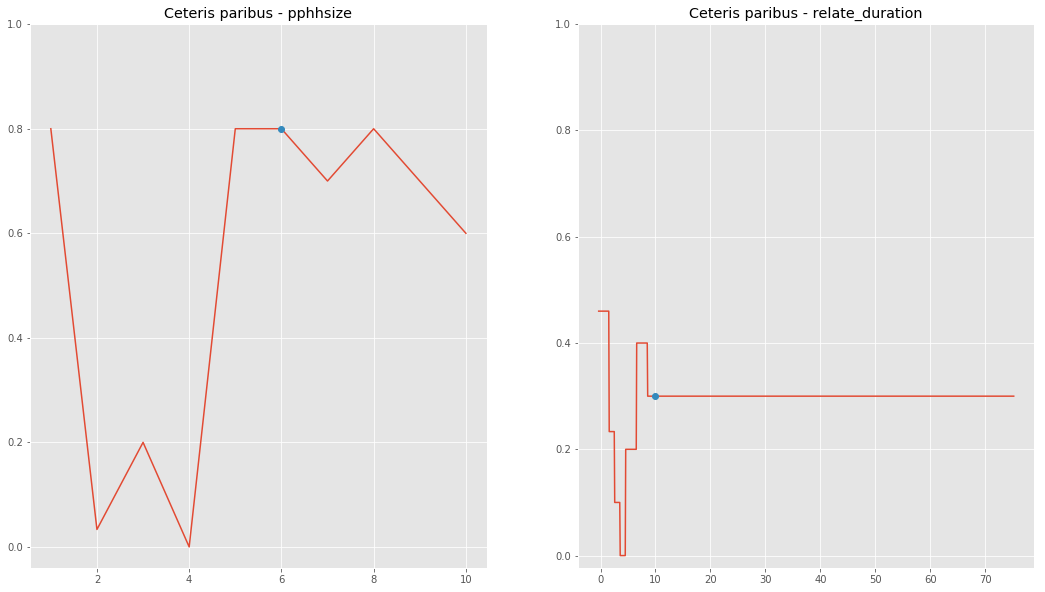

In [89]:
x, y, x_point, y_point = ceteris_paribus(X_data, 'pphhsize', chosen_index)
plt.subplot(1,2,1)
plt.title('Ceteris paribus - pphhsize')
plt.plot(x, y)
plt.plot(x_point, y_point, 'o')
plt.yticks([0,0.2, 0.4, 0.6, 0.8, 1])
x, y, x_point, y_point = ceteris_paribus(X_data, 'relate_duration', chosen_index)
plt.subplot(1,2,2)
plt.title('Ceteris paribus - relate_duration')
plt.plot(x, y)
plt.plot(x_point, y_point[0], 'o')
plt.yticks([0,0.2, 0.4, 0.6, 0.8, 1])
plt.show()